# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Use DataFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!


# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [1]:
import pandas as pd
import numpy as np
import json

def readjson(path):
    try:
        with open(path,'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError( "Please check the path and try agaian!!!")
        
loans = pd.read_csv('lending-club-data.csv')
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans', axis = 1, inplace = True)


/anaconda3/envs/AI-ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.

In [2]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'emp_length_num', 'grade_num', 'sub_grade_num', 'del

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [3]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

loans = loans[features+[target]]

loans.reset_index(drop=True, inplace=True)
for i in range(len(loans)):
    for j in loans.columns:
        x = loans.at[i, j]
        if isinstance(x, str):
            x = x.upper().strip()
            loans.at[i, j] = x
        else:
            continue
    
    
loans = pd.get_dummies(loans)

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [4]:
loans.dropna(inplace=True)

In [5]:
train_indx = readjson('module-8-assignment-1-train-idx.json')
validation_indx = readjson('module-8-assignment-1-validation-idx.json')
train_data = loans.iloc[train_indx].copy(deep=True)
validation_data = loans.iloc[validation_indx].copy(deep=True)
features = [i for i in train_data.columns.tolist() if i!='safe_loans']

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [GraphLab Create user guide](https://dato.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

## Making predictions
Just like we did in previous sections, let us consider a few positive and negative examples from the validation set. We will do the following:

Predict whether or not a loan is likely to default. Predict the probability with which the loan is likely to default.

First, let's grab 2 positive examples and 2 negative examples.

In [6]:
validation_safe_loans = validation_data[validation_data[target] == 1].copy(deep=True)
validation_risky_loans = validation_data[validation_data[target] == -1].copy(deep=True)

sample_validation_data_risky = validation_risky_loans[0:2].copy(deep=True)
sample_validation_data_safe = validation_safe_loans[0:2].copy(deep=True)

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_DEBT_CONSOLIDATION,purpose_HOME_IMPROVEMENT,purpose_HOUSE,purpose_MAJOR_PURCHASE,purpose_MEDICAL,purpose_MOVING,purpose_OTHER,purpose_SMALL_BUSINESS,purpose_VACATION,purpose_WEDDING
22,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
26,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
24,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
41,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,1,...,1,0,0,0,0,0,0,0,0,0


For each row in the sample_validation_data, write code to make model_5 predict whether or not the loan is classified as a safe loan. (Hint: if you are using scikit-learn, you can use the .predict() method)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
sample_model = GradientBoostingClassifier(n_estimators=5, max_depth=6)
X = train_data.drop('safe_loans',1)
sample_model.fit(X, train_data['safe_loans'])
sample_model.predict(sample_validation_data.drop('safe_loans',1))

array([ 1,  1, -1,  1])

In [8]:
sample_validation_data['safe_loans']

22    1
26    1
24   -1
41   -1
Name: safe_loans, dtype: int64

**Quiz question:** What percentage of the predictions on `sample_validation_data` did `sample_model` get correct?

### Prediction probabilities

For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

In [11]:
sample_model.predict_proba(sample_validation_data.drop('safe_loans',1))

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

**Quiz Question:** According to **sample_model**, which loan is the least likely to be a safe loan?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the model_5 on the validation_data. (Hint: if you are using scikit-learn, you can use the .score() method)

In [10]:
sample_model.score(validation_data.drop('safe_loans',1), validation_data['safe_loans'])

0.6613528651443343

Calculate the number of **false positives** made by the model on the validation_data.

In [13]:
predict_safeloans = sample_model.predict(validation_data.drop('safe_loans',1))
print ("False Positives: {}".format(sum(predict_safeloans > validation_data['safe_loans'])))

False Positives: 1653


## Comparison with decision trees

In [14]:
print ("False Negatives: {}".format(sum(predict_safeloans < validation_data['safe_loans'])))

False Negatives: 1491


Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?



In [16]:
cost = 20000*1653+10000*1491
print (cost)

47970000


## Most positive & negative loans
In this section, we will find the loans that are most likely to be predicted safe.

In [17]:
validation_data['predictions'] = sample_model.predict_proba(validation_data.drop('safe_loans',1))[:,1]

validation_data[['grade_A','grade_B','grade_C','grade_D','predictions']].sort_values('predictions', ascending = False).head(5)

,grade_A,grade_B,grade_C,grade_D,predictions
8021,1,0,0,0,0.673059
6422,1,0,0,0,0.661468
26126,1,0,0,0,0.661468
81153,1,0,0,0,0.661468
15960,1,0,0,0,0.661468


In [18]:
validation_data[['grade_A','grade_B','grade_C','grade_D','predictions']].sort_values('predictions', ascending = False).tail(5)

,grade_A,grade_B,grade_C,grade_D,predictions
84921,0,0,1,0,0.315969
101746,0,0,0,1,0.315969
27502,0,0,1,0,0.312806
58794,0,0,1,0,0.307334
84508,0,0,1,0,0.307334


## Effects of adding more trees
In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees.

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.

In [19]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_10.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_50.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_100.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [22]:
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_200.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)
model_500.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
model_10.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6653382162860836

In [25]:
model_50.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6851572598018095

In [26]:
model_100.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])


0.6880654890133563

In [27]:
model_200.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6896811719086601

In [28]:
model_500.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6893580353295993

## Plot the training and validation error vs. number of trees
In this section, we will plot the training and validation errors versus the number of trees to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need matplotlib in order to visualize the plots.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Steps to follow:

Step 1: Calculate the classification error for each model on the training data (train_data).

Step 2: Store the training errors into a list (called training_errors) that looks like this: [train_err_10, train_err_50, ..., train_err_500] 

Step 3: Calculate the classification error of each model on the validation data (validation_data).

Step 4: Store the validation classification error into a list (called validation_errors) that looks like this:[validation_err_10, validation_err_50, ..., validation_err_500]

In [30]:
train_err_10 = 1 - model_10.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_50 = 1 - model_50.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_100 = 1 - model_100.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_200 = 1 - model_200.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_500 = 1 - model_500.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

validation_err_10 = 1 - model_10.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_50 = 1 - model_50.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_100 = 1 - model_100.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_200 = 1 - model_200.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_500 = 1 - model_500.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

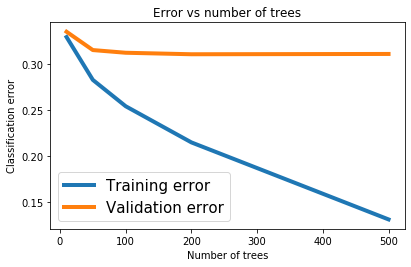

In [31]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Quiz question**: Does the training error reduce as the number of trees increases?

**Quiz question**: Is it always true that the validation error will reduce as the number of trees increases?